 ## Data Loading

We Start by loading the necessary tables from CSV files. we make sure to set low_memory=False when reading large files to handle memory efficiently.

In [16]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

In [3]:
# Load necessary tables
patients = pd.read_csv('PATIENTS.csv', low_memory=False)
admissions = pd.read_csv('ADMISSIONS.csv', low_memory=False)
icustays = pd.read_csv('ICUSTAYS.csv', low_memory=False)
chartevents = pd.read_csv('CHARTEVENTS.csv', low_memory=False)
labevents = pd.read_csv('LABEVENTS.csv', low_memory=False)


In [71]:
print(patients.columns)
print(admissions.columns)
print(icustays.columns)
print(chartevents.columns)
print(labevents.columns)

Index(['ROW_ID', 'SUBJECT_ID', 'GENDER', 'DOB', 'DOD', 'DOD_HOSP', 'DOD_SSN',
       'EXPIRE_FLAG'],
      dtype='object')
Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS',
       'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA'],
      dtype='object')
Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'DBSOURCE',
       'FIRST_CAREUNIT', 'LAST_CAREUNIT', 'FIRST_WARDID', 'LAST_WARDID',
       'INTIME', 'OUTTIME', 'LOS'],
      dtype='object')
Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'ITEMID', 'CHARTTIME',
       'STORETIME', 'CGID', 'VALUE', 'VALUENUM', 'VALUEUOM', 'WARNING',
       'ERROR', 'RESULTSTATUS', 'STOPPED'],
      dtype='object')
Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ITEMID', 'CHARTTIME', 'VALUE',
       'VALUENUM', 'VALUEUOM', 'FLAG']

## Data Preprocessing


#### Merge Tables


- To create a unified dataset, we merged PATIENTS, ADMISSIONS, and ICUSTAYS tables. This provides demographic details, ICU stay information, and mortality status.
- The MORTALITY target variable is set to 1 if the patient has a DEATHTIME, indicating in-hospital death.
- We calculate ICU stay duration in hours and filter for stays within the first 24 hours.


In [30]:
# Merge patients, admissions, and ICU stays on SUBJECT_ID and HADM_ID
merged_df = icustays.merge(admissions, on=['SUBJECT_ID', 'HADM_ID'], how='inner') \
                        .merge(patients, on='SUBJECT_ID', how='inner')

# Add the mortality flag as the target variable
merged_df['MORTALITY'] = merged_df['HOSPITAL_EXPIRE_FLAG']
print("Merged Data with Target:\n", merged_df.head())


Merged Data with Target:
    ROW_ID_x  SUBJECT_ID  HADM_ID  ICUSTAY_ID DBSOURCE FIRST_CAREUNIT  \
0       365         268   110404      280836  carevue           MICU   
1       366         269   106296      206613  carevue           MICU   
2       367         270   188028      220345  carevue            CCU   
3       368         271   173727      249196  carevue           MICU   
4       369         272   164716      210407  carevue            CCU   

  LAST_CAREUNIT  FIRST_WARDID  LAST_WARDID               INTIME  ...  \
0          MICU            52           52  2198-02-14 23:27:38  ...   
1          MICU            52           52  2170-11-05 11:05:29  ...   
2           CCU            57           57  2128-06-24 15:05:20  ...   
3          SICU            52           23  2120-08-07 23:12:42  ...   
4           CCU            57           57  2186-12-25 21:08:04  ...   

  HOSPITAL_EXPIRE_FLAG  HAS_CHARTEVENTS_DATA  ROW_ID GENDER  \
0                    1                     1 

## Feature Engineering


In [40]:
import pandas as pd

# Ensure INTIME and CHARTTIME are in datetime format
icustays['INTIME'] = pd.to_datetime(icustays['INTIME'])
chartevents['CHARTTIME'] = pd.to_datetime(chartevents['CHARTTIME'])

# Now, we can safely add Timedelta to the 'INTIME'
# First, we need to merge the chartevents with icustays to get the ICU stay information
merged_chartevents = pd.merge(chartevents, icustays[['ICUSTAY_ID', 'INTIME']], on='ICUSTAY_ID', how='inner')

# Filter Chart Events to get data within the first 24 hours of ICU stay
chartevents_24hr = merged_chartevents[merged_chartevents['CHARTTIME'] <= merged_chartevents['INTIME'] + pd.Timedelta(hours=24)]

# Example of important ITEMID for vital signs (Heart Rate, BP, etc.)
# ITEMID corresponds to various vital signs in the CHARTEVENTS table (assumed knowledge)
vital_signs_itemids = [220045, 220179, 220180, 220181, 220210, 220277]  # Adjust based on the actual dataset

# Filter for those ITEMIDs (representing key vital signs)
filtered_vitals = chartevents_24hr[chartevents_24hr['ITEMID'].isin(vital_signs_itemids)]

# Aggregating vital sign data (mean, min, max) over the first 24 hours
vital_agg = filtered_vitals.groupby(['ICUSTAY_ID', 'ITEMID']).agg({
    'VALUENUM': ['mean', 'max', 'min']
}).reset_index()

# Flatten multi-level columns
vital_agg.columns = ['ICUSTAY_ID', 'ITEMID', 'MEAN_VAL', 'MAX_VAL', 'MIN_VAL']

# Pivot the table to create one row per ICU stay, with different vital signs as columns
vital_features = vital_agg.pivot(index='ICUSTAY_ID', columns='ITEMID', values=['MEAN_VAL', 'MAX_VAL', 'MIN_VAL'])
vital_features.columns = ['_'.join(map(str, col)) for col in vital_features.columns]  # Flatten the column names
vital_features.reset_index(inplace=True)

# Merge vital signs data back to the main merged dataframe
merged_df = pd.merge(merged_df, vital_features, on='ICUSTAY_ID', how='left')

print(merged_df.head())


   ROW_ID_x  SUBJECT_ID  HADM_ID  ICUSTAY_ID DBSOURCE FIRST_CAREUNIT  \
0       365         268   110404      280836  carevue           MICU   
1       366         269   106296      206613  carevue           MICU   
2       367         270   188028      220345  carevue            CCU   
3       368         271   173727      249196  carevue           MICU   
4       369         272   164716      210407  carevue            CCU   

  LAST_CAREUNIT  FIRST_WARDID  LAST_WARDID              INTIME  ...  \
0          MICU            52           52 2198-02-14 23:27:38  ...   
1          MICU            52           52 2170-11-05 11:05:29  ...   
2           CCU            57           57 2128-06-24 15:05:20  ...   
3          SICU            52           23 2120-08-07 23:12:42  ...   
4           CCU            57           57 2186-12-25 21:08:04  ...   

  MAX_VAL_220180  MAX_VAL_220181  MAX_VAL_220210 MAX_VAL_220277  \
0            NaN             NaN             NaN            NaN   
1     

### Select Lab Results from LABEVENTS
Similarly, we select key lab results (e.g., glucose, sodium) within the first 24 hours.

In [44]:
# Ensure CHARTTIME and INTIME are datetime
labevents['CHARTTIME'] = pd.to_datetime(labevents['CHARTTIME'])
icustays['INTIME'] = pd.to_datetime(icustays['INTIME'])

# Merge on 'HADM_ID' if 'ICUSTAY_ID' is not available in labevents
merged_labevents = pd.merge(labevents, icustays[['HADM_ID', 'INTIME']], on='HADM_ID', how='inner')

# Filter Lab Events for the first 24 hours of ICU stay
lab_events_24hr = merged_labevents[merged_labevents['CHARTTIME'] <= merged_labevents['INTIME'] + pd.Timedelta(hours=24)]

# Define ITEMIDs for key lab tests (e.g., Sodium, Potassium, etc.)
lab_itemids = [50983, 50971, 50893]  # Adjust based on dataset

# Filter for key lab tests
filtered_labs = lab_events_24hr[lab_events_24hr['ITEMID'].isin(lab_itemids)]

# Aggregate lab results (mean, min, max) over 24 hours
lab_agg = filtered_labs.groupby(['HADM_ID', 'ITEMID']).agg({
    'VALUENUM': ['mean', 'max', 'min']
}).reset_index()

# Flatten multi-level columns
lab_agg.columns = ['HADM_ID', 'ITEMID', 'LAB_MEAN', 'LAB_MAX', 'LAB_MIN']

# Pivot the table to create one row per hospital admission (HADM_ID), with different lab tests as columns
lab_features = lab_agg.pivot(index='HADM_ID', columns='ITEMID', values=['LAB_MEAN', 'LAB_MAX', 'LAB_MIN'])
lab_features.columns = ['_'.join(map(str, col)) for col in lab_features.columns]  # Flatten column names
lab_features.reset_index(inplace=True)

# Merge lab results data back into the main dataframe (using HADM_ID here for consistency)
merged_df = pd.merge(merged_df, lab_features, on='HADM_ID', how='left')

print(merged_df.head())


   ROW_ID_x  SUBJECT_ID  HADM_ID  ICUSTAY_ID DBSOURCE FIRST_CAREUNIT  \
0       365         268   110404      280836  carevue           MICU   
1       366         269   106296      206613  carevue           MICU   
2       367         270   188028      220345  carevue            CCU   
3       368         271   173727      249196  carevue           MICU   
4       369         272   164716      210407  carevue            CCU   

  LAST_CAREUNIT  FIRST_WARDID  LAST_WARDID              INTIME  ...  \
0          MICU            52           52 2198-02-14 23:27:38  ...   
1          MICU            52           52 2170-11-05 11:05:29  ...   
2           CCU            57           57 2128-06-24 15:05:20  ...   
3          SICU            52           23 2120-08-07 23:12:42  ...   
4           CCU            57           57 2186-12-25 21:08:04  ...   

  MIN_VAL_220277  LAB_MEAN_50893  LAB_MEAN_50971 LAB_MEAN_50983 LAB_MAX_50893  \
0            NaN        8.266667        4.775000     131.37

### Data Cleaning and Preparation for Model

In [45]:
# Drop rows where the target variable is missing
merged_df.dropna(subset=['MORTALITY'], inplace=True)

# Fill missing values in vital and lab features with median or zero
vital_cols = [col for col in merged_df.columns if 'MEAN_VAL' in col or 'MAX_VAL' in col or 'MIN_VAL' in col]
lab_cols = [col for col in merged_df.columns if 'LAB_MEAN' in col or 'LAB_MAX' in col or 'LAB_MIN' in col]

merged_df[vital_cols] = merged_df[vital_cols].fillna(merged_df[vital_cols].median())
merged_df[lab_cols] = merged_df[lab_cols].fillna(merged_df[lab_cols].median())

# Define features (vital signs and lab results) and target (MORTALITY)
X = merged_df[vital_cols + lab_cols]
y = merged_df['MORTALITY']

# Split data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(X_train.shape, X_test.shape)


(43072, 27) (18460, 27)


## Model Training and Evaluation

### Result Analysis

In [54]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Make predictions
y_pred = (model.predict(X_test_scaled) > 0.5).astype("int32")

# Calculate accuracy and AUC-ROC score
accuracy = accuracy_score(y_test, y_pred)
y_pred_proba = model.predict(X_test_scaled)  # Probabilities for AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Deep Learning Model Accuracy: {accuracy}")
print(f"Deep Learning Model AUC-ROC: {roc_auc}")

# Classification report
print(classification_report(y_test, y_pred))


577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step
Deep Learning Model Accuracy: 0.8957204767063922
Deep Learning Model AUC-ROC: 0.7504477567662016
              precision    recall  f1-score   support

           0       0.90      1.00      0.94     16494
           1       0.75      0.03      0.06      1966

    accuracy                           0.90     18460
   macro avg       0.82      0.52      0.50     18460
weighted avg       0.88      0.90      0.85     18460



In [66]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Assume merged_df, vital_cols, and lab_cols are defined and X_lstm and y_lstm are prepared
# Combine the features for the FCNN
X_fcnn = merged_df[vital_cols + lab_cols].values  # All features (vitals and labs)
y_fcnn = merged_df['MORTALITY'].values            # Target variable

# Standardize the features
scaler = StandardScaler()
X_fcnn = scaler.fit_transform(X_fcnn)

# Split the data into training and testing sets
X_train_fcnn, X_test_fcnn, y_train_fcnn, y_test_fcnn = train_test_split(X_fcnn, y_fcnn, test_size=0.3, random_state=42)

# Define a Fully Connected Neural Network (FCNN) model
fcnn_model = Sequential()

# First dense layer with 128 units
fcnn_model.add(Dense(128, activation='relu', input_shape=(X_train_fcnn.shape[1],)))
fcnn_model.add(Dropout(0.3))  # Dropout layer to prevent overfitting

# Second dense layer with 64 units
fcnn_model.add(Dense(64, activation='relu'))
fcnn_model.add(Dropout(0.3))

# Third dense layer with 32 units
fcnn_model.add(Dense(32, activation='relu'))
fcnn_model.add(Dropout(0.3))

# Output layer with sigmoid activation for binary classification
fcnn_model.add(Dense(1, activation='sigmoid'))

# Compile the model
fcnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
fcnn_model.summary()




/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                │ (None, 128)            │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,953 (54.50 KB)

 Trainable params: 13,953 (54.50 KB)

 Non-trainable params: 0 (0.00 B)

In [67]:
# Train the FCNN model
history_fcnn = fcnn_model.fit(X_train_fcnn, y_train_fcnn, epochs=30, batch_size=64, validation_data=(X_test_fcnn, y_test_fcnn))


Epoch 1/30
673/673 ━━━━━━━━━━━━━━━━━━━━ 1s 559us/step - accuracy: 0.8712 - loss: 0.4071 - val_accuracy: 0.8956 - val_loss: 0.3050
Epoch 2/30
673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.8919 - loss: 0.3216 - val_accuracy: 0.8960 - val_loss: 0.3087
Epoch 3/30
673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.8956 - loss: 0.3068 - val_accuracy: 0.8962 - val_loss: 0.3108
Epoch 4/30
673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - accuracy: 0.8938 - loss: 0.3094 - val_accuracy: 0.8963 - val_loss: 0.3076
Epoch 5/30
673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - accuracy: 0.8959 - loss: 0.3012 - val_accuracy: 0.8959 - val_loss: 0.3167
Epoch 6/30
673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - accuracy: 0.8951 - loss: 0.3034 - val_accuracy: 0.8962 - val_loss: 0.3170
Epoch 7/30
673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - accuracy: 0.8971 - loss: 0.2993 - val_accuracy: 0.8957 - val_loss: 0.3204
Epoch 8/30
673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.8945 - loss: 0.3034 - 

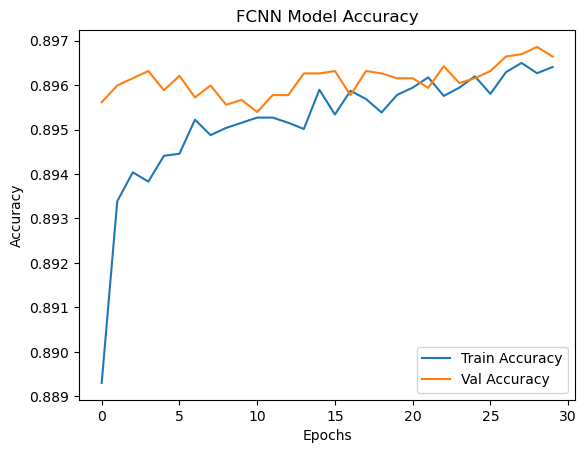

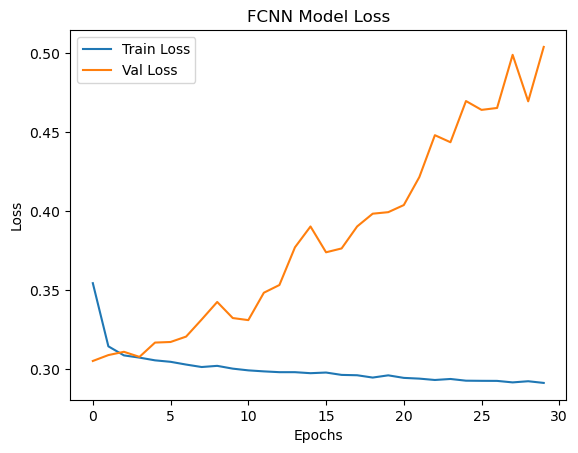

577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step - accuracy: 0.8990 - loss: 0.5653
Test Accuracy: 0.8966413736343384


In [68]:

# Plot the training history (accuracy)
plt.plot(history_fcnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_fcnn.history['val_accuracy'], label='Val Accuracy')
plt.title('FCNN Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training history (loss)
plt.plot(history_fcnn.history['loss'], label='Train Loss')
plt.plot(history_fcnn.history['val_loss'], label='Val Loss')
plt.title('FCNN Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate on the test set
test_loss, test_accuracy = fcnn_model.evaluate(X_test_fcnn, y_test_fcnn)
print(f"Test Accuracy: {test_accuracy}")